
<h1><center>Predicting NBA Games</center></h1>
<h4><center>Aditya Kudva, Priyanka Chatterjee, Serhan Oztekin</center></h4>

# Project Content

In this project, we will predict the outcome of NBA games by using statistical data. The libraries we will be using are mainly pandas, matplotlib, numpy and sklearn.
The dataset has been scraped from the official NBA http://www.nba.com/ and ESPN http://www.espn.com/.

The topics will be covered are as follows;

- [Installing the Libraries](#Installing-the-Libraries)
- [Player Efficiency Rating](#Player-Efficiency-Rating)
- [Loading Data](#Loading-Data)
- [Scrapping Team Stats](#Scrapping-Team-Stats)
- [Creating Dataframes and Computing Basic Statistics](#Creating-Feature-Dataframes)
- [Building the Classifier](#Classification)
- [Evaluating the results](#Evaluation)
- [Future Work](#Future-Work)
- [References](#References)
- [Glossary](#Glossary)

Once we have the team statistics for each NBA team, in order to extend our feature set, we will also take player statistics into consideration. In the end, we will combine both team and individual statistics for each team. For that matter, we came up with the idea of computing performance score for each player, then taking an average of individual performance scores of players for each team. The only thing we should think about is the way we could possibly calculate individual scores based on their historical data.



Turns out, there already exists a way of calculating performance scores for players called "player efficiency rating" PER, which has been introduced by John Hollinger. The PER is for per-minute rating and calculated with set of metrics such as DRB (Defensive Rebound Percentage), TOV (Turnovers) etc. You can find the actual formula for PER calculation here https://www.basketball-reference.com/about/per.html.

Luckily, we can scrape the PER scores for NBA players from here http://insider.espn.com/nba/hollinger/statistics/_/page/ and use it in our project for further computations.

# Installing the Libraries

We have used 4 libraries in our project which can easily be installed using PIP:
* pip install pandas
* pip install bs4
    * pip install html.parser
    * pip install lxml
* pip install urllib
* pip isntall requests
* pip isntall numpy

As you can see above it is important to even install the the two parsers in the BS4 library, as we will make use of each depending on compatibility with webpages.

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib
import requests
import numpy as np

# Player Efficiency Rating

At first we were just considering individual stats. But then we realised that the top-ated, star players in a team do make a huge difference to a team's winning capability. When a highly efficient player is dropped from a team, the team's winning percentage could drop signinficanly for the remaining season. This is why we considered John Hollinger's PER, which allows us to compare players even when there is a disparity in their minutes played. The following is a code  that scraps the PER rating for every NBA player in the 2017-18 season.

In [3]:
def per_scrap(link):
    df_list = []
    for i in range(1,12):
        res = requests.get(link + str(i))
        soup = BeautifulSoup(res.content,'lxml')
        table = soup.find_all('table')[0] 
        df = pd.read_html(str(table))
        df_list.append(df[0])
    df = pd.concat(df_list, ignore_index=True)
    df = df.dropna(axis=0, how='any')
    df = df[df[1] != 'PLAYER']
    df = pd.concat([df[1], df[11]],axis=1,join='inner')
    df['Team'] = df[1].apply(lambda x:x.split(',')[1].strip())
    df.rename(index=str, columns={11: "per"}, inplace=True)
    return df

In [14]:
scrap_link = "http://insider.espn.com/nba/hollinger/statistics/_/page/"
per_df = per_scrap(scrap_link)
per_df.head()

,1,per,Team
2,"James Harden, HOU",29.87,HOU
3,"Anthony Davis, NO",28.98,NO
4,"LeBron James, CLE",28.65,CLE
5,"Stephen Curry, GS",28.32,GS
6,"Giannis Antetokounmpo, MIL",27.37,MIL


Finally, we average out each player's PER for a given team, so that we could merge it as a team stat for every team. This helps us consider a combination of individual stats along with the contributions a player makes to a team and add it to the team stats.

In [5]:
#calculate average PER value for every team
average_per_team = {}
for idx,each in per_df.iterrows():
    if each.Team in average_per_team:
        prev_array = average_per_team[each.Team]
        prev_array.append(float(each.per))
        average_per_team[each.Team] = prev_array
    else:
        average_per_team[each.Team] = [float(each.per)]

        
for key, value in average_per_team.items():
    average_per_team[key] = np.mean(value)

# Loading Data

There are a lot of team stats that could be considered as potential features. The teams in the NBA go through the a lot of changes every year so it is only resonable to restrict our training data to a particular year. A study by Harvard Sports Analysis, states that for winning NBA games 'offense matters slightly more.' So we will try to focus slightly more on offensive stats, but will give an adequate amount of importance to defensive stats while considering features as well. The following function `add_stat` takes the link of the webpage that is compatible with lxml parsing and the name of the feature to be added. This lets us add features with ease and eventually select the ones that will get us more accuracy in prediction.  

In [6]:
def add_stat(link, name):
    res = requests.get(link)
    soup = BeautifulSoup(res.content,'lxml')
    table = soup.find_all('table')[0] 
    df = pd.read_html(str(table))[0]
    df = pd.concat([df['Team'], df['2017']], axis=1, join='inner')
    df = df.sort_values('Team')
    df = df.reset_index(drop=True)
    df = df.rename(index=str, columns={ "2017": name})
    if(df[name].dtype == object):
        df[name] = df[name].apply(lambda x:x.rstrip('%'))
    df[name] = df[name].astype(np.float64)
    df = df[name].to_frame()
    return df

# Scrapping Team Stats

For scrapping most of the team stats we used Beautiful Soup's html parser, since both NBA and ESPN website tables are not compatible with lxml parsers. We scrap some of the most important team stats from http://www.espn.com/nba/standings/_/group/league. 

In [7]:
def team_stats(link):
    #link = "http://www.espn.com/nba/standings/_/group/league"
    f = urllib.request.urlopen(link)
    html_file = f.read()

    soup = BeautifulSoup(html_file, 'html.parser')

    #getting tema names sorted in decscending order of win percentage
    abbr = soup.find_all('abbr')
    team_list = []
    team_codes = []
    for a in abbr:
        team_codes.append(a.text)
        team_list.append(a['title'])

    team_list = ['Los Angeles Clippers' if x=='LA Clippers' else x for x in team_list]
    tr = soup.find_all('tr')
    team_stats_list = []

    for row in tr[-30:]:
        values = row.find_all('span')
        temp_list = []
        for value in values:
            temp_list.append(value.contents[0])
        team_stats_list.append(temp_list)

    stats_df = pd.DataFrame(columns = ['Win PCT', 'Home Win PCT', 'Away Win PCT', 'L10', 'per_value'])

    for team_stats in team_stats_list:

        stats_df = stats_df.append({'Win PCT': float(team_stats[2]), 'Home Win PCT': float(team_stats[4].split('-')[0])/(float(team_stats[4].split('-')[0]) + float(team_stats[4].split('-')[1])), 'Away Win PCT': float(team_stats[5].split('-')[0])/(float(team_stats[5].split('-')[0]) + float(team_stats[5].split('-')[1])), 'L10' : int(team_stats[12].split('-')[0])/(float(team_stats[12].split('-')[0]) + float(team_stats[12].split('-')[1]))},ignore_index=True)

    team_df = pd.DataFrame({'Team': team_list})
    team_codes_df = pd.DataFrame({"Team_code": team_codes})
    stats_df = pd.concat([team_df, stats_df, team_codes_df], axis=1, join='inner')
    stats_df = stats_df.sort_values('Team')
    stats_df = stats_df.reset_index(drop=True)
    three_df = add_stat('https://www.teamrankings.com/nba/stat/three-point-pct', '3PT%')
    fg_df = add_stat('https://www.teamrankings.com/nba/stat/effective-field-goal-pct', 'FG%')
    reb_df = add_stat('https://www.teamrankings.com/nba/stat/offensive-rebounding-pct', 'OREB%')
    dreb_df = add_stat('https://www.teamrankings.com/nba/stat/defensive-rebounding-pct', 'DREB%')
    ofg_df = add_stat('https://www.teamrankings.com/nba/stat/opponent-effective-field-goal-pct', 'OFG%')
    oclose_df = add_stat('https://www.teamrankings.com/nba/stat/win-pct-close-games', 'OCLS%')
    stats_df = pd.concat([stats_df.reset_index(drop=True),three_df.reset_index(drop=True),fg_df.reset_index(drop=True)], axis=1) #add feature here
        
    for idx, row in stats_df.iterrows():
        stats_df.loc[idx, 'per_value'] = average_per_team[row.Team_code]

    return stats_df

In [13]:
link = "http://www.espn.com/nba/standings/_/group/league"
stats = team_stats(link)
stats

,Team,Win PCT,Home Win PCT,Away Win PCT,L10,per_value,Team_code,3PT%,FG%
0,Atlanta Hawks,0.293,0.390244,0.195122,0.3,13.414444,ATL,36.0,51.2
1,Boston Celtics,0.671,0.658537,0.682927,0.6,13.373333,BOS,37.5,51.7
2,Brooklyn Nets,0.341,0.365854,0.317073,0.5,13.411667,BKN,35.6,51.4
3,Charlotte Hornets,0.439,0.512195,0.365854,0.5,13.703000,CHA,36.9,50.8
4,Chicago Bulls,0.329,0.414634,0.243902,0.3,13.475455,CHI,35.5,49.7
5,Cleveland Cavaliers,0.610,0.707317,0.512195,0.7,15.471250,CLE,37.0,54.6
6,Dallas Mavericks,0.293,0.365854,0.219512,0.2,15.158889,DAL,36.0,51.3
7,Denver Nuggets,0.561,0.756098,0.365854,0.7,18.085000,DEN,37.1,53.6
8,Detroit Pistons,0.476,0.609756,0.341463,0.7,14.477500,DET,37.3,51.2
9,Golden State Warriors,0.707,0.707317,0.707317,0.4,16.577333,GS,38.4,56.4


We have succesfully scrapped the stats we need. This is what the following stats stand for:
* Win PCT - Total Win Percentage
* Home Win PCT - Win Percentage at home
* Away Win PCT - Win Percentage as visitor
* L10 - Win percentage in last 10 games
* per_value - Average PER rating for each team
* 3PT% - Total 3PT field goal percentage
* FG% - Field goal percentage

As you can see in our code we scapped other features such as rebounds, offensive field goals and opponent shooting percentage(defensive stat). But after performing feature slection we decided to keep only those in the dataframe above for best prediction accuracy.

Now, we will go ahead and scrap the results for every NBA game in the 2017-18 season.

In [11]:
def nba_results(link):
    visitor = []
    home = []
    visitor_pts = []
    home_pts = []
    month_list = ['october','november', 'december', 'january', 'february', 'march', 'april']
    for month in month_list:
        request_link = link + month +'.html'
        res = requests.get(request_link)
        soup = BeautifulSoup(res.text, 'html.parser')
        tbody = soup.find_all('tbody')
        tr = tbody[0].find_all('tr')
        for row in tr:
            td = row.find_all('td')
            for stat in td:
                if(stat['data-stat'] == 'visitor_team_name'):
                    visitor.append(stat.a.contents[0])

                elif(stat['data-stat'] == 'home_team_name'):
                    home.append(stat.a.contents[0])

                elif(stat['data-stat'] == 'visitor_pts'):
                    visitor_pts.append(stat.contents[0])

                elif(stat['data-stat'] == 'home_pts'):
                    home_pts.append(stat.contents[0])

    visitor_df = pd.DataFrame({'visitor': visitor})
    home_df = pd.DataFrame({'home': home})
    visitor_pts_df = pd.DataFrame({'visitor_pts': visitor_pts})
    home_pts_df = pd.DataFrame({'home_pts': home_pts})

    results_df = pd.concat([visitor_df, home_df, visitor_pts_df, home_pts_df], axis=1)
    #WL =1 if home team wins, else 0
    results_df[['visitor_pts','home_pts']] = results_df[['visitor_pts','home_pts']].apply(pd.to_numeric)
    results_df['WL'] = np.where(results_df['home_pts'] > results_df['visitor_pts'] , 1, 0)
    return results_df



In [12]:
request_link = "https://www.basketball-reference.com/leagues/NBA_2018_games-"
results = nba_results(request_link)
results

,visitor,home,visitor_pts,home_pts,WL
0,Boston Celtics,Cleveland Cavaliers,99,102,1
1,Houston Rockets,Golden State Warriors,122,121,0
2,Milwaukee Bucks,Boston Celtics,108,100,0
3,Atlanta Hawks,Dallas Mavericks,117,111,0
4,Charlotte Hornets,Detroit Pistons,90,102,1
5,Brooklyn Nets,Indiana Pacers,131,140,1
6,New Orleans Pelicans,Memphis Grizzlies,91,103,1
7,Miami Heat,Orlando Magic,109,116,1
8,Portland Trail Blazers,Phoenix Suns,124,76,0
9,Houston Rockets,Sacramento Kings,105,100,0


The above table contains the points for both home and visitor team. WL is 1 if home team wins and 0 otherwise.

# Creating Feature Dataframes

Once we have our `results` and `stats` tables, we adjust the team statistics based on their status meaning whether they are visitor, or home team. In particular, we adjust the PCT metric for each team. Intuitively, PCT will be much higher for a team if it's playing home, and much less if it's playing as a visitor team.

The way we will build our features (`stats_merged`) is that for each game result, we will fetch the historical statistics of teams doing a match together, and append them to a single row i.e for each row we will have statistics from both teams, and label them according to their results.

In [11]:
stats_merged = pd.DataFrame()
for idx, each in results.iterrows():
    visitor_stats = stats.loc[stats['Team'] == each.visitor]
    home_stats = stats.loc[stats['Team'] == each.home]
    visitor_stats = visitor_stats.drop('Home Win PCT', axis = 1)
    home_stats = home_stats.drop('Away Win PCT', axis = 1)
    
    visitor_stats.rename(columns={'Away Win PCT': 'local_pct'}, inplace=True)
    home_stats.rename(columns={'Home Win PCT': 'local_pct'}, inplace=True)
    

    
    temp = pd.concat([visitor_stats.reset_index(drop=True),
                      home_stats.reset_index(drop=True)], axis=1)
    
    stats_merged = stats_merged.append(temp, ignore_index=True)
    

The result dataframe which consists of team statistics for teams having a match is as follows;

In [12]:
stats_merged.head(5)

,Team,Win PCT,local_pct,L10,per_value,Team_code,3PT%,FG%,Team,Win PCT,local_pct,L10,per_value,Team_code,3PT%,FG%
0,Boston Celtics,0.671,0.682927,0.6,13.373333,BOS,37.5,51.7,Cleveland Cavaliers,0.610,0.707317,0.7,15.471250,CLE,37.0,54.6
1,Houston Rockets,0.793,0.756098,0.7,16.934000,HOU,36.1,54.8,Golden State Warriors,0.707,0.707317,0.4,16.577333,GS,38.4,56.4
2,Milwaukee Bucks,0.537,0.463415,0.6,13.596667,MIL,35.6,53.3,Boston Celtics,0.671,0.658537,0.6,13.373333,BOS,37.5,51.7
3,Atlanta Hawks,0.293,0.195122,0.3,13.414444,ATL,36.0,51.2,Dallas Mavericks,0.293,0.365854,0.2,15.158889,DAL,36.0,51.3
4,Charlotte Hornets,0.439,0.365854,0.5,13.703000,CHA,36.9,50.8,Detroit Pistons,0.476,0.609756,0.7,14.477500,DET,37.3,51.2


Now let's remove the team names from out features set in order to pass it to the classifier

In [13]:
features = stats_merged.drop(['Team','Team_code'], axis=1)

Now, let's fetch our labels indicating whether a game was a lost or win for a given home team. We will not consider the points at this stage, instead the match result as a binary value will be enough to classify.

In [14]:
labels = results['WL']
results.head(5)

,visitor,home,visitor_pts,home_pts,WL
0,Boston Celtics,Cleveland Cavaliers,99,102,1
1,Houston Rockets,Golden State Warriors,122,121,0
2,Milwaukee Bucks,Boston Celtics,108,100,0
3,Atlanta Hawks,Dallas Mavericks,117,111,0
4,Charlotte Hornets,Detroit Pistons,90,102,1


<a id='Classification'></a>
# Classification

The time has finally come for the classification part. In this section, we will use Logistic Regression classifier to predict the match results. The intuition behind using Logistic Regression is mainly because it is one of the most simple, yet robust algorithms in classification challenges.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33)

logreg = LogisticRegression()

lr = logreg.fit(X_train, y_train )

<a id='Evaluation'></a>
# Evaluation

- Let's evaluate our model and see how well we did in predicting the results of the NBA Games.
- The first measure we will be using for evaluating our model is the ROC curve.
- ROC curve which stands for Receiver Operating Characteristics is a very common evalution method for binary classifiers. We will predict the probability estimates of our model to build the ROC curve. The <span style="color:red"> dotted line</span> in the middle shows how good could we do if we used a random classifier. Our model result which is shown by the <span style="color:blue"> blue curve</span> certainly performs better.

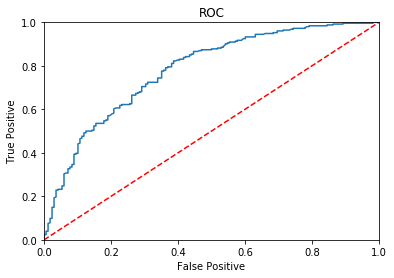

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
auc = roc_auc_score(y_test, lr.predict(X_test))

false_positive, true_positive, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])


plt.figure()
plt.plot(false_positive, true_positive)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])


plt.plot([0, 1], [0, 1],'r--')


plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC')
plt.show()

`lr.score()` will give us the ratio of: <br></br> `correct predictions / total number of data points`. However, we will use extra methods to evaluate our model.

In [20]:
print('Accuracy on test set: {:.2f}'.format(lr.score(X_test, y_test)))
print('Accuracy on training set: {:.2f}'.format(lr.score(X_train, y_train)))

Accuracy on test set: 0.74
Accuracy on training set: 0.68


- Let's also look at the <b>F-1 Measure</b>

F1-score or F-measure, is calculated as follows: `2 * ((precision * recall)/(precision + recall))`
<br></br>
where Precision (P) is defined as the number of true positives (T_p) over the number of true positives plus the number of false positives (F_p).
<br></br>
Recall (R) is defined as the number of true positives (T_p) over the number of true positives plus the number of false negatives (F_n).
<br></br>
<br></br> You can read more about F-measure here: https://en.wikipedia.org/wiki/F1_score

In [21]:
# F-Measure
from sklearn.metrics import classification_report
print(classification_report(y_test, lr.predict(X_test)))

             precision    recall  f1-score   support

          0       0.69      0.61      0.65       168
          1       0.76      0.82      0.79       254

avg / total       0.73      0.74      0.73       422



# Future Work

To increase the accuracy of our classifier we would want to take statistical parameters of features, such as variance and use them along with the scrapped features. We also would explore geographic features like distance travelled by the players upto a week before the game, and the altitude difference for the visitor team from home court, in an attempt to increase classifier accuracy.

# References

- ESPN Stats: https://www.basketball-reference.com/about/per.html
- Harvard Sports Analysis: http://harvardsportsanalysis.org/2014/05/what-wins-in-the-nba-offense-or-defense/
- PER: http://www.espn.com/nba/columns/story?columnist=hollinger_john&id=2850240

<a id='Glossary'></a>
# Glossary
https://www.basketball-reference.com/about/glossary.html